In [25]:
import pandas as pd
import numpy as np
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt

In [37]:
# Function to convert time series data to supervised learning format
def series_to_supervised(data, In=1, out=1, dropnan=True):
    df = pd.DataFrame(data)
    columns = []
    for i in range(In, 0, -1):
        columns.append(df.shift(i))
    for i in range(0, out):
        columns.append(df.shift(-i))
    agg = concat(columns, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# Function to split the data into train and test sets
def train_test_split(data, n):
    return data[:-n, :], data[-n:, :]

# Function to make a one-step forecast with Random Forest
def random_forest_forecast(train, test_x):
    train = np.asarray(train)
    train_x, train_y = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)  # Optimization parameters
    model.fit(train_x, train_y)
    yhat = model.predict([test_x])
    return yhat[0]

# Function for walk-forward validation
def walk_forward_validation(data, test_n):
    predictions = []
    train, test = train_test_split(data, test_n)
    history = [x for x in train]
    for i in range(len(test)):
        test_x, test_y = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, test_x)
        predictions.append(yhat)
        history.append(test[i])
        print(f'expected={test_y}, predicted={yhat}')
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions, history

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Forecasting the next 90 days
def forecast_next_days(data, n_days):
    predictions = []
    train, test = train_test_split(data, n_days)
    history = [x for x in train]
    for i in range(len(test)):
        test_x, test_y = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, test_x)
        predictions.append(yhat)
        history.append(test[i])
    return predictions


In [27]:
# Load the dataset
file_path = 'viettri_quality.csv'  # Adjust the file path as needed
series_all = pd.read_csv(file_path, header=0, index_col=0, parse_dates=True)
series = series_all['pm25']
# Convert the PM2.5 series to supervised learning
data = series_to_supervised(series.values, In=6)

In [28]:
# Split the data with a 7:3 ratio
train_size = int(len(data) * 0.7)
train, test = train_test_split(data, len(data) - train_size)

In [29]:
# Perform walk-forward validation on the test set
mae, y, yhat, history = walk_forward_validation(data, len(test))

expected=44.0, predicted=33.20760555850329
expected=33.0, predicted=52.441460721661514
expected=70.0, predicted=37.3507273312421
expected=56.0, predicted=47.66460389920339
expected=28.0, predicted=49.375377244604444
expected=21.0, predicted=28.673483875770447
expected=20.0, predicted=34.951261972867904
expected=17.0, predicted=27.80405689532224
expected=28.0, predicted=22.060580121879948
expected=1.0, predicted=27.270115267914402
expected=66.0, predicted=24.54771907041506
expected=18.0, predicted=50.205029871961344
expected=45.0, predicted=36.69217771871219
expected=46.0, predicted=45.972211280286764
expected=1.0, predicted=40.511064335062194
expected=73.0, predicted=47.67101149505779
expected=19.0, predicted=37.164445384841585
expected=84.0, predicted=43.51442215821444
expected=15.0, predicted=42.83663265533528
expected=18.0, predicted=40.757314186664345
expected=1.0, predicted=39.66372447281629
expected=101.0, predicted=39.48983839716675
expected=22.0, predicted=33.91077076490815
exp

In [40]:
print('MAE:', mae)
# Calculate RMSE
rmse = mean_squared_error(y, yhat, squared=False)
print('RMSE:', rmse)
mape = mean_absolute_percentage_error(y, yhat)
print('MAPE:', mape)

MAE: 16.972196994038978
RMSE: 23.088069884566355
MAPE: 155.55985723025822


In [38]:
# Fit the model on the entire dataset with optimization parameters
model = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)
model.fit(data[:, :-1], data[:, -1])
# Forecast the next 90 days
n_days = 90
forecast = forecast_next_days(data, n_days)

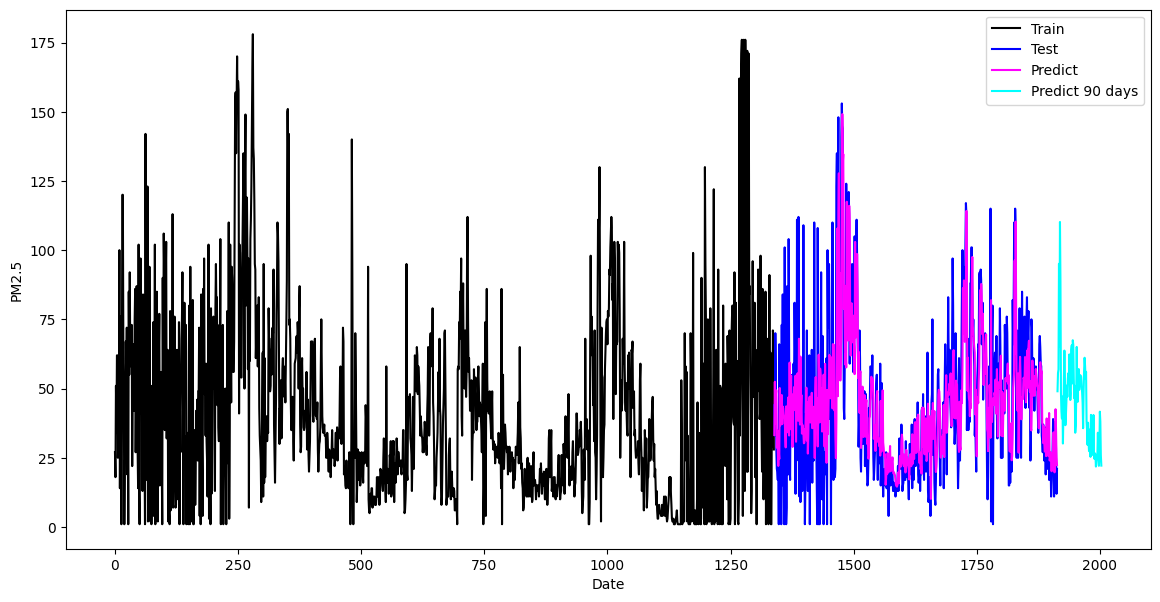

In [39]:
# Prepare data for plotting
train_index = range(len(train))
test_index = range(len(train), len(train) + len(test))
forecast_index = range(len(train) + len(test), len(train) + len(test) + n_days)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train_index, [x[-1] for x in train], color='black', label='Train')
plt.plot(test_index, y, color='blue', label='Test')
plt.plot(test_index, yhat, color='magenta', label='Predict')
plt.plot(forecast_index, forecast, color='cyan', label='Predict 90 days')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


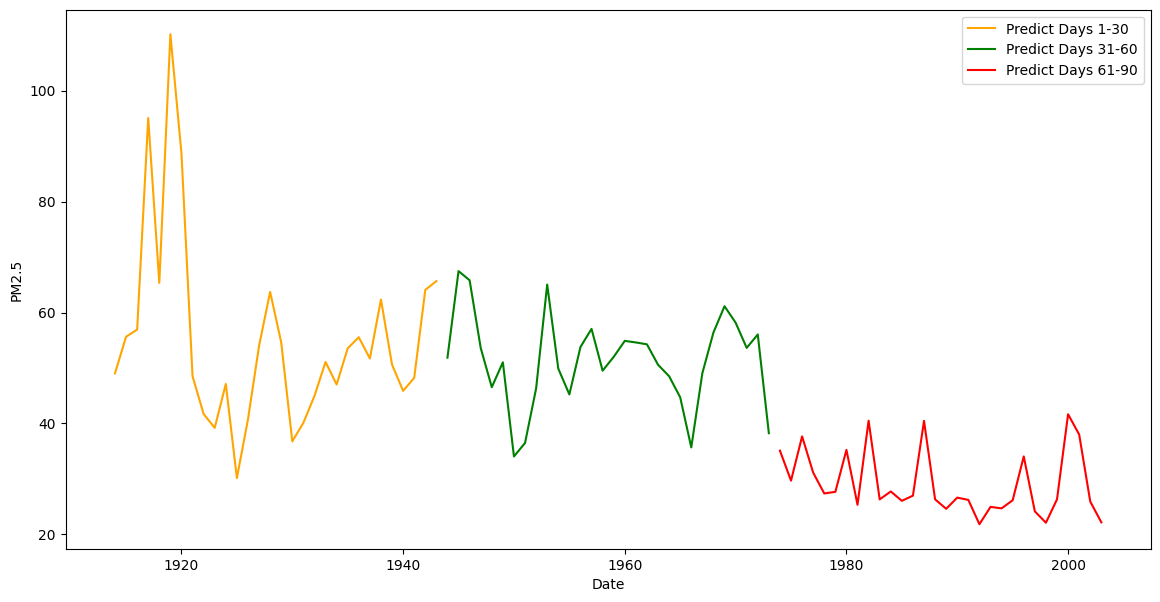

In [44]:
plt.figure(figsize=(14, 7))

# Split forecast into 3 segments
segment_size = 30
forecast_segments = [forecast[i*segment_size:(i+1)*segment_size] for i in range(3)]
colors = ['orange', 'green', 'red']  # Màu cho từng phần
for i, segment in enumerate(forecast_segments):
    plt.plot(forecast_index[i*segment_size:(i+1)*segment_size], segment, color=colors[i], label=f'Predict Days {i*segment_size+1}-{(i+1)*segment_size}')

plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.show()
